# Tumor Segmentation with FDR Control

This notebook demonstrates conformal FDR control for tumor segmentation using the generic conformal risk control framework.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

# Import utils
from utils import (
    fdr_loss,
    compute_or_load_fdr_matrix,
    compute_or_load_prediction_rate,
    apply_ltt_fdr_control,
    apply_crc_fdr_control,
    estimate_beta
)

# Import generic conformal risk control
sys.path.insert(0, '..')
from generic import GenericConformalRiskControl, GenericStabilityEstimator

!pip install --upgrade pip -q
!pip install -U --no-cache-dir gdown --pre -q

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd']  # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

In [ ]:
# Problem setup
n = 500  # number of calibration points
alpha = 0.1  # target FDR level
delta = 0.1  # LTT failure probability

# Debug mode: Set to True for faster debugging, False for full experiments
DEBUG_MODE = True
USE_CACHED_BETA = True

if DEBUG_MODE:
    theta_grid = np.linspace(0, 1, 50)
    n_replicates = 10
    thetas_viz = np.linspace(0, 1, 50)
    n_bootstrap_beta = 100
else:
    theta_grid = np.linspace(0, 1, 1000)
    n_replicates = 100
    thetas_viz = np.linspace(0, 1, 200)
    n_bootstrap_beta = 1000

# Precompute FDR matrix for ALL data (before any splitting)
# This is the most expensive operation, so we do it once upfront
fdr_matrix_full = compute_or_load_fdr_matrix(sgmd, gt_masks, theta_grid, verbose=True)
prediction_rate_full = compute_or_load_prediction_rate(sgmd, theta_grid)

# Estimate beta using all data
beta_hat_precomputed = estimate_beta(fdr_matrix_full, alpha, theta_grid, n_bootstrap_beta, method="def")
print("Cached-beta-hat: ", beta_hat_precomputed)

Loaded FDR matrix from cache: 1798 images x 50 thetas
Cached-beta-hat:  3.095060052355743e-05


In [4]:
# Split into calibration and validation sets
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)
# Extract calibration and validation FDR matrices
fdr_matrix_cal = fdr_matrix_full[idx, :]
prediction_rate_cal = prediction_rate_full[idx, :]
fdr_matrix_val = fdr_matrix_full[~idx, :]
prediction_rate_val = prediction_rate_full[~idx, :]

In [15]:
# Run all three methods
results_conservative = apply_crc_fdr_control(
    fdr_matrix_cal, fdr_matrix_val, prediction_rate_val,
    alpha, theta_grid, beta_hat=beta_hat_precomputed, verbose=True
)

results_standard = apply_crc_fdr_control(
    fdr_matrix_cal, fdr_matrix_val, prediction_rate_val,
    alpha, theta_grid, beta_hat=0.0, verbose=True
)

results_ltt = apply_ltt_fdr_control(
    fdr_matrix_cal, fdr_matrix_val, prediction_rate_val, alpha, delta, theta_grid, verbose=True
)

# Summary table
print()
print("="*85)
print(f"{'Metric':<40} {'CRC-C':<15} {'CRC':<15} {'LTT':<15}")
print("-"*85)
print(f"{'Beta (stability adjustment)':<40} {beta_hat_precomputed:<.6f}")
print(f"{'Effective alpha':<40} {alpha-beta_hat_precomputed:<15.4f} {alpha:<15.4f} {alpha:<15.4f}")
print(f"{'Threshold':<40} {results_conservative['theta_hat']:<15.4f} {results_standard['theta_hat']:<15.4f} {results_ltt['theta_hat']:<15.4f}")
print(f"{'Empirical FDR':<40} {results_conservative['empirical_fdr']:<15.4f} {results_standard['empirical_fdr']:<15.4f} {results_ltt['empirical_fdr']:<15.4f}")
print(f"{'Prediction rate':<40} {results_conservative['prediction_rate']:<15.4f} {results_standard['prediction_rate']:<15.4f} {results_ltt['prediction_rate']:<15.4f}")
print("="*85)

CRC-C: thetahat=0.4286, FDR=0.1081, pred_rate=0.1242
CRC: thetahat=0.4286, FDR=0.1081, pred_rate=0.1242
LTT: θ̂=0.4490, FDR=0.0932, pred_rate=0.1220

Metric                                   CRC-C           CRC             LTT            
-------------------------------------------------------------------------------------
Beta (stability adjustment)              0.000031
Effective alpha                          0.1000          0.1000          0.1000         
Threshold                                0.4286          0.4286          0.4490         
Empirical FDR                            0.1081          0.1081          0.0932         
Prediction rate                          0.1242          0.1242          0.1220         


## Visualization: FDR Curve and Comparison

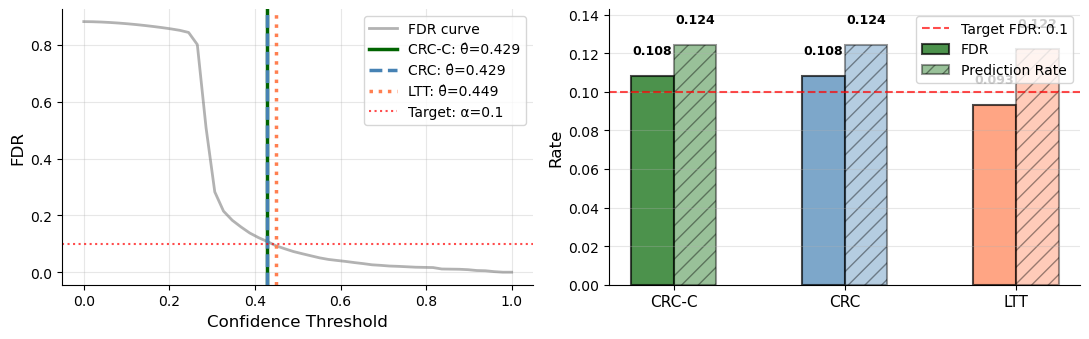

In [18]:
# Compute FDR and prediction rate curves
fdr_curve = []
prediction_rate_curve = []

for theta in thetas_viz:
    idx_theta = np.argmin(np.abs(theta_grid - theta))
    fdr_val = fdr_matrix_val.mean(axis=0)[idx_theta]
    pred_rate = prediction_rate_val.mean(axis=0)[idx_theta]
    fdr_curve.append(fdr_val)
    prediction_rate_curve.append(pred_rate)

fdr_curve = np.array(fdr_curve)
prediction_rate_curve = np.array(prediction_rate_curve)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Plot 1: FDR curve with threshold comparison
ax = axes[0]
ax.plot(thetas_viz, fdr_curve, label='FDR curve', linewidth=2, color='gray', alpha=0.6)
ax.axvline(x=results_conservative['theta_hat'], linewidth=2.5, linestyle='-', 
           label=f"CRC-C: θ̂={results_conservative['theta_hat']:.3f}", color='darkgreen')
ax.axvline(x=results_standard['theta_hat'], linewidth=2.5, linestyle='--', 
           label=f"CRC: θ̂={results_standard['theta_hat']:.3f}", color='steelblue')
ax.axvline(x=results_ltt['theta_hat'], linewidth=2.5, linestyle=':', 
           label=f'LTT: θ̂={results_ltt["theta_hat"]:.3f}', color='coral')
ax.axhline(y=alpha, linewidth=1.5, linestyle='dotted', 
           label=f'Target: α={alpha}', color='red', alpha=0.7)
ax.set_xlabel('Confidence Threshold', fontsize=12)
ax.set_ylabel('FDR', fontsize=12)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2: Performance bars
ax = axes[1]
width = 0.25
x_pos = np.arange(3)
fdrs = [results_conservative['empirical_fdr'], results_standard['empirical_fdr'], results_ltt['empirical_fdr']]
pred_rates = [results_conservative['prediction_rate'], results_standard['prediction_rate'], results_ltt['prediction_rate']]
colors_bars = ['darkgreen', 'steelblue', 'coral']
labels_bars = ['CRC-C', 'CRC', 'LTT']

bars1 = ax.bar(x_pos - width/2, fdrs, width, label='FDR',
               color=colors_bars, alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, pred_rates, width, label='Prediction Rate',
               color=colors_bars, alpha=0.4, edgecolor='black', linewidth=1.5, hatch='//')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
            f'{height1:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
            f'{height2:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.axhline(y=alpha, linewidth=1.5, linestyle='--', color='red', alpha=0.7,
           label=f'Target FDR: {alpha:.1f}')
ax.set_ylabel('Rate', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_bars, fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim([0, max(max(fdrs), max(pred_rates)) * 1.15])
ax.grid(True, alpha=0.3, axis='y')
sns.despine(ax=ax)

plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig('./plots/fdr-control-comparison.pdf', dpi=150)
plt.show()

## Multi-Replicate Experiment

To thoroughly compare the methods, we run multiple replicates with different random calibration/validation splits.

In [ ]:
results_experiment = {
    'crc_c_fdr': [], 'crc_c_pred_rate': [], 'crc_c_threshold': [], 'crc_c_beta': [],
    'crc_fdr': [], 'crc_pred_rate': [], 'crc_threshold': [],
    'ltt_fdr': [], 'ltt_pred_rate': [], 'ltt_threshold': []
}

start_time_exp = time.time()

for rep in range(n_replicates):
    if (rep + 1) % max(1, n_replicates // 5) == 0:
        print(f"  Replicate {rep + 1}/{n_replicates}...")
    
    # Random split
    idx_rep = np.array([1] * n + [0] * (sgmd.shape[0] - n)) > 0
    np.random.shuffle(idx_rep)
    
    # Index into cached FDR matrix
    fdr_matrix_cal_rep = fdr_matrix_full[idx_rep, :]
    fdr_matrix_val_rep = fdr_matrix_full[~idx_rep, :]
    
    # Estimate beta for this replicate
    beta_hat_rep = None
    if USE_CACHED_BETA:
        beta_hat_rep = beta_hat_precomputed
    else: 
        beta_hat_rep = estimate_beta(fdr_matrix_cal_rep, alpha, theta_grid, n_bootstrap_beta, method="def")
    
    # CRC-C
    res_crc_c = apply_crc_fdr_control(
        fdr_matrix_cal_rep, fdr_matrix_val_rep, prediction_rate_val,
        alpha, theta_grid, beta_hat=beta_hat_rep, verbose=False
    )
    results_experiment['crc_c_fdr'].append(res_crc_c['empirical_fdr'])
    results_experiment['crc_c_pred_rate'].append(res_crc_c['prediction_rate'])
    results_experiment['crc_c_threshold'].append(res_crc_c['theta_hat'])
    results_experiment['crc_c_beta'].append(beta_hat_rep)
    
    # CRC (Standard)
    res_crc = apply_crc_fdr_control(
        fdr_matrix_cal_rep, fdr_matrix_val_rep, prediction_rate_val,
        alpha, theta_grid, beta_hat=0.0, verbose=False
    )
    results_experiment['crc_fdr'].append(res_crc['empirical_fdr'])
    results_experiment['crc_pred_rate'].append(res_crc['prediction_rate'])
    results_experiment['crc_threshold'].append(res_crc['theta_hat'])
    
    # LTT
    res_ltt = apply_ltt_fdr_control(
        fdr_matrix_cal_rep, fdr_matrix_val_rep, prediction_rate_val, alpha, delta, theta_grid, verbose=False
    )
    results_experiment['ltt_fdr'].append(res_ltt['empirical_fdr'])
    results_experiment['ltt_pred_rate'].append(res_ltt['prediction_rate'])
    results_experiment['ltt_threshold'].append(res_ltt['theta_hat'])

# Convert to arrays
for key in results_experiment:
    results_experiment[key] = np.array(results_experiment[key])

elapsed_exp = time.time() - start_time_exp
print(f"\nCompleted {n_replicates} replicates in {elapsed_exp:.2f}s ({elapsed_exp/n_replicates:.2f}s per replicate)\n")

# Summary statistics
print("="*85)
print("RESULTS SUMMARY")
print("="*85)
print(f"{'Metric':<35} {'CRC-C':<16} {'CRC':<16} {'LTT':<16}")
print("-"*85)
print(f"{'Mean Beta':<35} {results_experiment['crc_c_beta'].mean():<16.4f} {'—':<16} {'—':<16}")
print(f"{'Mean FDR':<35} {results_experiment['crc_c_fdr'].mean():<16.4f} {results_experiment['crc_fdr'].mean():<16.4f} {results_experiment['ltt_fdr'].mean():<16.4f}")
print(f"{'Std FDR':<35} {results_experiment['crc_c_fdr'].std():<16.4f} {results_experiment['crc_fdr'].std():<16.4f} {results_experiment['ltt_fdr'].std():<16.4f}")
print(f"{'Mean Prediction Rate':<35} {results_experiment['crc_c_pred_rate'].mean():<16.4f} {results_experiment['crc_pred_rate'].mean():<16.4f} {results_experiment['ltt_pred_rate'].mean():<16.4f}")
print(f"{'Mean Threshold':<35} {results_experiment['crc_c_threshold'].mean():<16.4f} {results_experiment['crc_threshold'].mean():<16.4f} {results_experiment['ltt_threshold'].mean():<16.4f}")
print("-"*85)
print(f"{'FDR violations (> α)':<35} {(results_experiment['crc_c_fdr'] > alpha).sum():<16} {(results_experiment['crc_fdr'] > alpha).sum():<16} {(results_experiment['ltt_fdr'] > alpha).sum():<16}")
print(f"{'Violation rate':<35} {100*(results_experiment['crc_c_fdr'] > alpha).mean():<15.1f}% {100*(results_experiment['crc_fdr'] > alpha).mean():<15.1f}% {100*(results_experiment['ltt_fdr'] > alpha).mean():<15.1f}%")
print("="*85)

## Distribution Comparison (KDE Plots)

In [ ]:
# Distribution comparison plots
fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

# Plot 1: FDR Distribution
ax = axes[0]
sns.kdeplot(results_experiment['crc_c_fdr'], ax=ax, label='CRC-C',
            color='darkgreen', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_fdr'], ax=ax, label='CRC',
            color='steelblue', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_fdr'], ax=ax, label='LTT',
            color='coral', linewidth=3, fill=True, alpha=0.3)
ax.axvline(x=alpha, linewidth=2.5, linestyle='--', color='gray',
           label=f'Target: α = {alpha}', alpha=0.7)

ax.set_xlabel('FDR', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2: Prediction Rate Distribution
ax = axes[1]
sns.kdeplot(results_experiment['crc_c_pred_rate'], ax=ax, label='CRC-C',
            color='darkgreen', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_pred_rate'], ax=ax, label='CRC',
            color='steelblue', linewidth=3, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_pred_rate'], ax=ax, label='LTT',
            color='coral', linewidth=3, fill=True, alpha=0.3)

ax.set_xlabel('Prediction Rate (Fraction of Pixels Selected)', fontsize=13)
ax.set_ylabel('Density', fontsize=13)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('./plots/fdr-control-kde-distributions.pdf', dpi=150)
plt.show()

## Example Visualizations

In [ ]:
# Example segmentations using the conservative threshold
theta_final = results_conservative['theta_hat']
print(f"Example segmentations with threshold θ̂ = {theta_final:.4f}\n")

for i in range(10):
    rand_idx = np.random.choice(example_indexes)
    img = imread('../data/polyps/examples/' + str(rand_idx) + '.jpg')
    gt_mask = imread('../data/polyps/examples/' + str(rand_idx) + '_gt_mask.jpg')
    predicted_mask = resize(sgmd[rand_idx] >= theta_final, 
                           (img.shape[0], img.shape[1]), 
                           anti_aliasing=False)
    
    fig, axs = plt.subplots(1, 3, figsize=(8.64, 4.76))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].axis('off')
    
    if i == 0:
        axs[0].set_title('Input')
        axs[1].set_title('Predicted Mask')
        axs[2].set_title('Ground Truth Mask')
    
    plt.tight_layout()
    plt.show()